In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [4]:
import numpy as np
import pandas as pd

In [5]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [6]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [8]:
shuffle(colors)

# Sythetic data

In [9]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [10]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [12]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [13]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [14]:
get_2_stays = lambda n: 11.4*np.random.rand(n) - 5.7

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

In [80]:
def get_clusters_x(t_arr, loc_arr, dist_thresh, time_thresh, verbose=False):
    """
    Get a list of cluster indices

    :param t_arr: np.array Trajectory array of timepoints
    :param timepoint: float Timepoint
    :param time_thresh: float buff around timepoint  
    :param direction: int gets the min or max index of a region
    
    :return: int endpoint index of a region
    
    """
    get_err = lambda x1, x2: abs(x1-x2) #np.sqrt((x1-x2)**2)
    
    # Output list of indices: [[beg., end],[beg., end], ...] 
    clusters = []

    m = 0

    # The current cluster indices: [n_0, n_1, ... ]
    new_cluster = []
    
    # Pass through the list of events
    for n in range(0,loc_arr.size-3):

        # Check: is the time within the time thresh?
        if abs(t_arr[n+1] - t_arr[n]) <= time_thresh:
            event_loc = loc_arr[n+1]
        else: 
            continue

        # Get the current cluster mean
        cluster_mean = np.mean(loc_arr[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(loc_arr[m:n+2])

        err1 = get_err(cluster_mean, event_loc)
        err2 = get_err(cluster_mean, new_cluster_mean)
        
        if verbose: print(f"{n:5d}, {err1:7.3f}, {err2:7.3f}, {dist_thresh:7.3f}")
 
        # Checks: 
        # 1. new event is within dist. thresh of current clust.
        # 2. new mean - current mean is within dist. thresh.
        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= loc_arr.size-5):
            #if verbose: print("append")
            new_cluster.append(n)
        else:
            # Save the current cluster and prepare restart
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                # Since this is an incomplete method (clusters will be merged after), 
                # can keep this; otherwise, would lose small clusters
                #if (abs(t_arr[new_cluster[-1]]-t_arr[new_cluster[0]]) > time_thresh):
                clusters.append(new_cluster)
                app = 'closed'
            #if verbose: print(txt+app)
            new_cluster = []

            # Update starting point
            m=n+1
            
    return clusters

In [511]:
event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

stays = get3(1, 3)
#stays = get1()

In [316]:
time_thresh = 1/6
dist_thresh=0.25

In [682]:
time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

clusters = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters))

clusters_rev = get_clusters_x(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
print(len(clusters_rev))

'''plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);''';

36
34


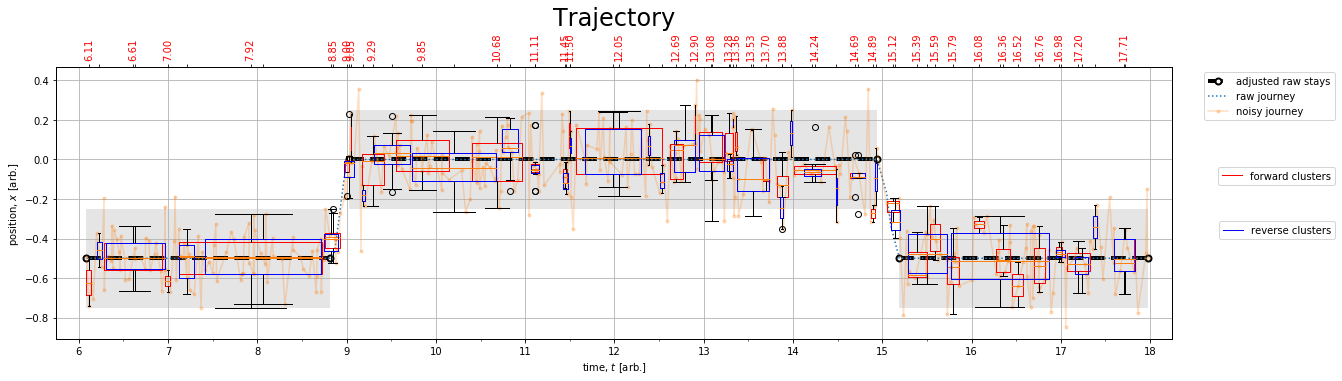

In [683]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [642]:
from helper__metric_box__explore import eval_synth_data

In [684]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.965
 0.773
[[  1  11]
 [ 90 307]]

backward
 0.985
 0.804
[[  7   5]
 [ 78 319]]


## Development

In [285]:
from helper__gaps import merge_clusters

In [286]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

### Early gap-method

7
7


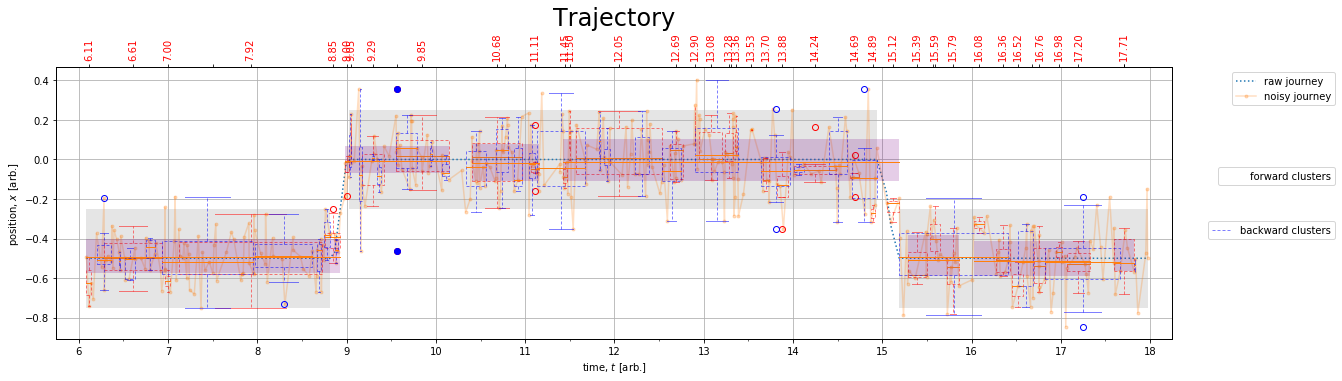

In [685]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)



new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters))
axt = get_cluster_boxplot(new_clusters, time_arr, noise_arr, axt, **kwargs_filled)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)
_, labels, _, _ = get_boxplot_quants(time_arr, noise_arr, clusters)
for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr, noise_arr, axt, **kwargs_unfilled)
_, labels, _, _ = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters_rev))
axt = get_cluster_boxplot(new_clusters_rev, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [686]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.971
 0.940
[[  1  11]
 [ 24 373]]

backward
 0.971
 0.940
[[  1  11]
 [ 24 373]]


### Later gap method

In [289]:
from helper__gaps import get_intercluster_metrics

In [687]:
for c1,c2 in zip(clusters[:-1],clusters[1:]):
    
    gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh, 3.4)
    
    print(f"{gap_time:5.3f}, {min_allowed:5.3f}", 
          gap_time < min_allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

0.146, 0.204 True 	 -0.625  -0.585  -0.499 	  0.040   0.085
0.040, 0.201 True 	 -0.499  -0.557  -0.616 	  0.058   0.058
0.095, 0.250 True 	 -0.616  -0.412  -0.491 	  0.204   0.079
0.035, 0.196 True 	 -0.491  -0.431  -0.391 	  0.060   0.041
0.051, 0.278 True 	 -0.391  -0.195  -0.013 	  0.196   0.182
0.024, 0.202 True 	 -0.013   0.016   0.106 	  0.029   0.090
0.116, 0.204 True 	  0.106  -0.015  -0.009 	  0.122   0.006
0.134, 0.204 True 	 -0.009   0.067   0.017 	  0.076   0.049
0.261, 0.236 False 	  0.017  -0.102   0.014 	  0.119   0.116
0.102, 0.292 True 	  0.014   0.196  -0.049 	  0.182   0.244
0.277, 0.178 False 	 -0.049  -0.062  -0.089 	  0.013   0.027
0.027, 0.228 True 	 -0.089  -0.012   0.121 	  0.077   0.132
0.071, 0.206 True 	  0.121  -0.004   0.006 	  0.125   0.010
0.091, 0.224 True 	  0.006  -0.069   0.049 	  0.075   0.118
0.135, 0.204 True 	  0.049   0.079   0.176 	  0.030   0.097
0.041, 0.217 True 	  0.176   0.151   0.003 	  0.025   0.147
0.030, 0.200 True 	  0.003  -0.038   0

In [291]:
from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2

3
3


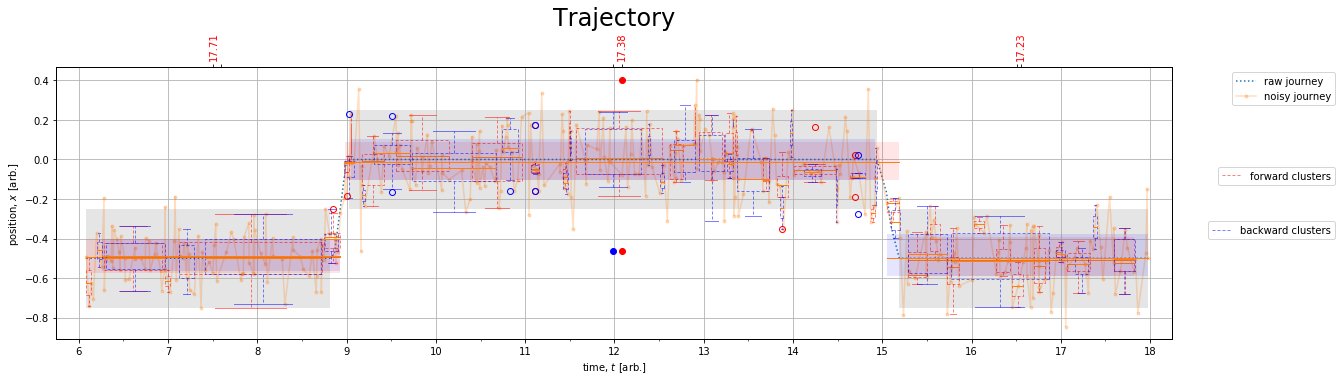

In [688]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters_2))
axt = get_cluster_boxplot(new_clusters_2, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_unfilled)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)
print(len(new_clusters_rev_2))
axt = get_cluster_boxplot(new_clusters_rev_2, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [295]:
from helper__metric_box__explore import iqr_metrics, get_iqr, get_iqr_mask

In [689]:
total_indices = []
for c in new_clusters_2:
    total_indices.extend(c)

In [690]:
total_indices_rev = []
for c in new_clusters_rev_2:
    total_indices_rev.extend(list(set(c).intersection(set(total_indices))))
total_indices_rev = sorted(total_indices_rev)

In [691]:
total_mindices = []
for c in new_clusters_2:
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    total_mindices.extend(mask[0].tolist())

In [692]:
total_mindices_rev = []
final_clusters = []
for c in new_clusters_rev_2:
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices)))
    total_mindices_rev.extend(cluster)
    final_clusters.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices_rev)

In [693]:
time_arr.size, len(total_indices),  len(total_mindices), len(total_indices_rev), len(total_mindices_rev)

(409, 400, 198, 393, 177)

(5.5, 18.25)

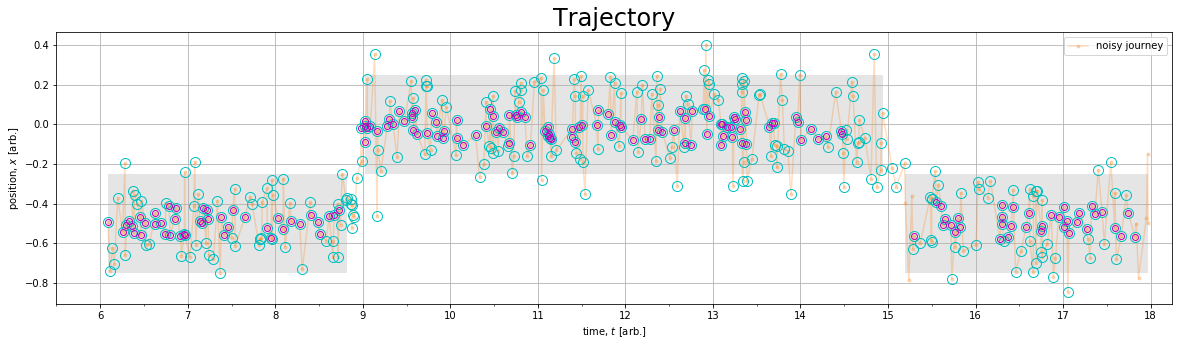

In [694]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

In [695]:
final_cluster = []
for c in final_clusters:
    final_cluster.extend(c)

print(len(final_cluster))

177


In [696]:
for n in range(3):
    print(f"{time_arr[final_clusters[n][0]]:7.4f}",
         f"{t_segs[3*n]:7.4f}", 
         f"{time_arr[final_clusters[n][-1]]:7.4f}",
         f"{t_segs[3*n+1]:7.4f}")

 6.0858  6.0858  8.7281  8.8147
 8.9819  9.0222 14.4769 14.9392
15.2975 15.1903 17.8231 17.9733


(5.5, 18.25)

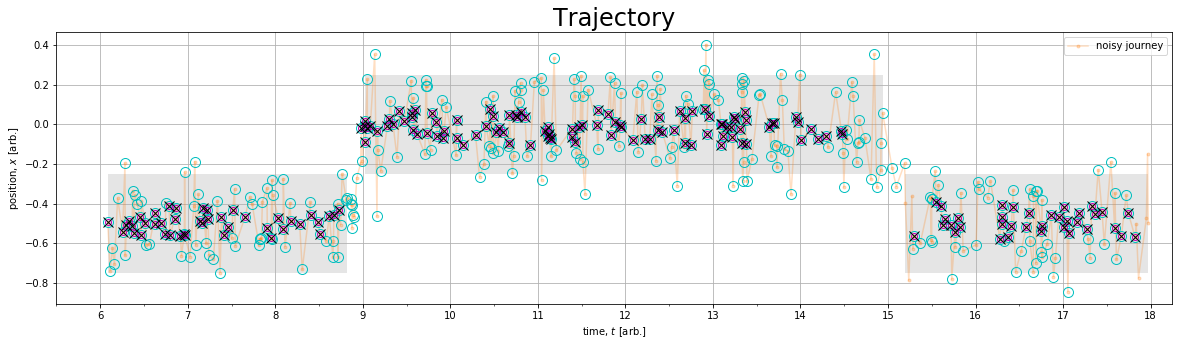

In [697]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')
ax.plot(time_arr[final_cluster], noise_arr[final_cluster], "kx", markersize=10, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [376]:
def extend_cluster(t_arr, x_arr, cluster, configs, dist_thresh, verbose=False):
    
    results = _extend_edge(t_arr, x_arr, cluster[-1], cluster[0], [x_arr[cluster].mean()], configs, dist_thresh, verbose)

    cluster += results[1]

    results = _extend_edge(t_arr, x_arr, cluster[0], cluster[-1], [x_arr[cluster].mean()], configs, dist_thresh, verbose)

    cluster = results[1] + cluster

    return cluster
    
def intersecting_bounds(a1,a2,b1,b2):
    
    return (((a1 >= b1) & (a1 <= b2)) | 
            ((a2 >= b1) & (a2 <= b2)) | 
            ((b1 >= a1) & (b1 <= a2)) | 
            ((b2 >= a1) & (b2 <= a2)))    

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])

def extend_final_clusters(t_arr, x_arr, clusters, configs, verbose=False):
    
    from stay_classification.box_classifier.box_method import extend_edge

    clust = clusters[0]
    #_configs = configs.copy()
    #_configs['dist_thresh'] = get_iqr(x_arr[clust])
    new_clusters = [extend_cluster(t_arr, x_arr, clust.copy(), configs, dist_thresh, verbose)]    

    #dist_thresh = configs['dist_thresh']
    
    for clust in clusters[1:]:

        #_configs = configs.copy()
        #_configs['dist_thresh'] = get_iqr(x_arr[clust])        
        c = extend_cluster(t_arr, x_arr, clust.copy(), configs, dist_thresh, verbose)
        
        # check the IQR is within the allowed threshold
        dist_criterion = False
        if get_iqr(x_arr[c])<2*dist_thresh:
            dist_criterion = True
            
        c_last = new_clusters[-1]            
        
        # Check if new cluster overlaps with the previous one
        embed_criterion = False
        if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)        
        
        print(f"[{ clust[0]:4d},{ clust[-1]:4d}]," + "\t"\
              f"{t_arr[clust[0]]:6.3f}...{t_arr[clust[-1]]:6.3f}" + "\t"\
              f"{x_arr[clust].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[clust]):6.3f}," + "\t\t\t"\
              f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
              f"{t_arr[c[0]]:6.3f}...{t_arr[c[-1]]:6.3f}" + "\t"\
              f"{x_arr[c].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[c]):6.3f},", \
              dist_criterion, embed_criterion)
        
        
        # check the IQR is within the allowed threshold
        dist_criterion0 = False
        if get_iqr(x_arr[clust])<2*dist_thresh:
            dist_criterion0 = True
                    
        # Check if new cluster overlaps with the previous one
        embed_criterion0 = False
        if len(new_clusters)>0:
            embed_criterion0 = inter_bounds(clust,c_last) 
            
        if dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        elif dist_criterion0 & (not embed_criterion0) & (get_iqr(x_arr[clust]) < get_iqr(x_arr[c])):
            new_clusters.append(clust)
        '''if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)
            print(f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
                  f"[{c_last[0]:4d},{c_last[-1]:4d}]")

        # ... if there is an overlap, get the one with the smaller IQR
        # ... 1. remove last, append new if dist_crit == True
        if dist_criterion & embed_criterion:
            if get_iqr(noise_arr[c])<get_iqr(noise_arr[c_last]):
                new_clusters[-1] = c       
            else:
                pass
        # ... if no overlap and dist_crit == True, append
        elif dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        else:
            pass'''
    
    return new_clusters

```
configs['count_thresh'] = 10
configs['dist_thresh'] = dist_thresh

final_final_clusters = extend_final_clusters(time_arr, noise_arr, final_clusters, configs, True)
```

In [698]:
final_final_cluster = []
for c in final_final_clusters:
    final_final_cluster.extend(c)

print(len(final_final_cluster))

132


In [667]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box, get_directional_indices, get_thresh_mean, check_means, get_time_ind
from helper__metric_box__explore import _get_iqr

def _extend_edge(t_arr, x_arr, working_index, fixed_index, means, configs, *quantiles, verbose=False):
    """
    Extend the edge of a potential box to include more points. 

    :param t_arr: np.array Trajectory array of timepoints
    :param x_arr: np.array Trajectory array of locations
    :param working_index: np.array Timepoint index to be extended
    :param fixed_index: np.array Timepoint index to be fixed
    :param fixed_index: [float] List of means; only one is used
        
    
    :param configs: dict containing the parameters used to define the box
    :param verbose: bool To select printing metrics to stdio
    
    :return: [float] means for the extension.
    :return: [int] new indices included in the extension
    :return: bool Indicates whether the means have converged
    
    """
    
    count_thresh = configs['count_thresh']
    #dist_thresh = configs['dist_thresh']
    
    keep_running = (working_index > 1) & (working_index < len(x_arr)-1)
    
    indices = []
    
    if working_index < fixed_index: 
        # Go backwards in time
        direction = -1
    else: 
        # Go forwards in time
        direction = 1
        
    mean = means[-1]
    converged_mean = mean
    converged_mean_ind0 = working_index
    
    while keep_running:
        
        #print(mean, direction)
        # Update and store the working index
        working_index += direction*1
        indices.append(working_index)
        
        # Update and store the mean
        if direction == -1:
            mean = get_thresh_mean(x_arr[working_index:fixed_index], mean, dist_thresh)
        else:
            mean = get_thresh_mean(x_arr[fixed_index:working_index], mean, dist_thresh)
        
        means.append(mean)    
        
        if np.isnan(mean):
            #print(mean)
            break
        
        # Stopping criteria:
        # if the thresholded mean doesn't change upon getting new samples
        # * if the duration is too long and there are sufficient number of samples
        
        if mean != converged_mean:
            converged_mean = mean
            converged_mean_ind = working_index
            converged_mean_ind0 = working_index
        else:
            converged_mean_ind = working_index
        
        time_diff = abs(t_arr[fixed_index]-t_arr[working_index])
        ctime_diff = abs(t_arr[converged_mean_ind0]-t_arr[converged_mean_ind])                                                         
        if ((ctime_diff>1.0) & (mean == converged_mean)): 
            if verbose: print('cdrop', ctime_diff)
            break        
        
        
        # When the mean either converges or stops
        if ((len(indices)>count_thresh) | ((time_diff>0.5) & (len(indices)>5))):  
            #print(time_diff,len(indices))
            nr_events = min(len(indices), count_thresh)
            # see also: bug_check_means(means,nr_events,0.25)
            if check_means(means, configs, nr_events):
                if verbose: print('drop', time_diff)
                break       
                    
                    
        #print(f"{t_arr[working_index]:.3f} {time_diff:.3f} {ctime_diff:.3f}", \
        #      len(indices), fixed_index, working_index, converged_mean_ind0, converged_mean_ind, \
        #      f"\t{mean:.5f} {x_arr[working_index]:.3f} {mean+dist_thresh:.5f}",)#,[m == m0 for m in means[-count_thresh:]])            
                    
        keep_running = (working_index > 1) & (working_index < len(x_arr)-1)

    return means, indices, keep_running

In [536]:
def get_iqr_mask_x(sub_arr, offset, iqr_bounds, iqr_fact = 1.5, within=True):

    #TODO: rename `x_arr` --> `sub_arr`, `cluster` --> `offset` 
    
    # Mask to include only events within the IQR
    if iqr_bounds != None:
        print(iqr_bounds)
        q25, q75 = iqr_bounds
    else:
        q25, q75 = _get_iqr(sub_arr)
    
    iqr = abs(q75 - q25)
        
    if within:
        mask = np.where((sub_arr > (q25 - iqr_fact * iqr)) & (sub_arr < (q75 + iqr_fact * iqr)))
        
    else:
        mask =  np.where((sub_arr <= (q25 - iqr_fact * iqr)) | (sub_arr >= (q75 + iqr_fact * iqr)))
    
    mask[0][:] += offset
    
    return mask

(-0.5730806796573034, -0.41328555409849543)
(-0.5730806796573034, -0.41328555409849543)
(-0.5730806796573034, -0.41328555409849543)
0 90 0 112
(-0.10610946047513273, 0.07735783762870702)
(-0.10610946047513273, 0.07735783762870702)
(-0.10610946047513273, 0.07735783762870702)
(-0.10610946047513273, 0.07735783762870702)
103 300 103 317
(-0.5797937706869677, -0.3948923869815359)
(-0.5797937706869677, -0.3948923869815359)
325 403 325 406


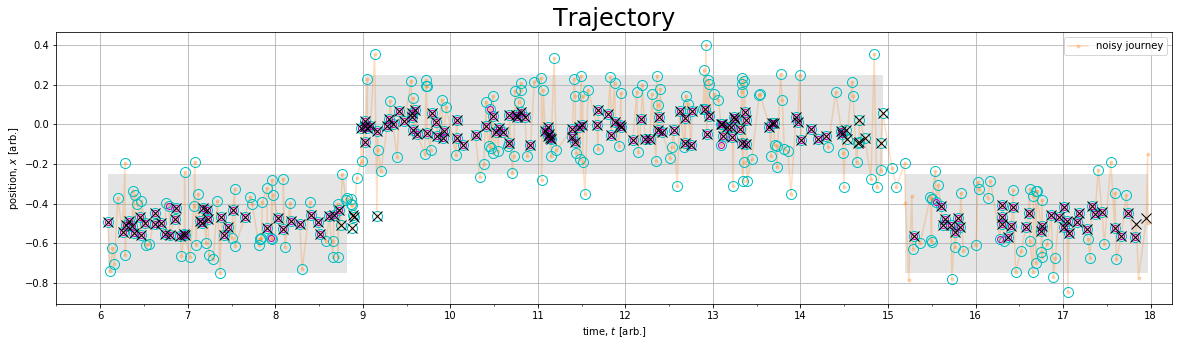

In [701]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

for c in final_clusters:

    new_end = get_time_ind(time_arr,time_arr[c[-1]], time_thresh, 1)

    last_ind = c[-1]
    keep_going = True
    while keep_going:
        
        cc = get_iqr_mask_x(noise_arr[c[0]:new_end], c[0], (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        
        if cc[-1]!=last_ind:
            last_ind = cc[-1]
        else:
            break

        new_end = get_time_ind(time_arr,time_arr[new_end], 2*time_thresh, 1)
            
    
    ax.plot(time_arr[cc], noise_arr[cc], "kx", markersize=10, markerfacecolor='None')
            
    print(c[0], c[-1], cc[0], cc[-1])

In [540]:
from helper__metric_box__explore import extend_cluster, extend_clusters, extend_edge

In [566]:
def get_bounded_events(x_arr, cluster, mininmum, maximum, within=True):

    #TODO: rename `x_arr` --> `sub_arr`, `cluster` --> `offset` 
    
    # Mask to include only events within the IQR
    sub_arr = x_arr.copy()
    
    if within:
        mask = np.where((sub_arr > mininmum) & (sub_arr < maximum))
        
    else:
        mask =  np.where((sub_arr <= mininmum) | (sub_arr >= maximum))
    
    mask[0][:] += cluster[0]
    
    return mask[0]

(-0.5730806796573034, -0.41328555409849543)
Backwards
0 90 0
(-0.5730806796573034, -0.41328555409849543)
0 0 0 0

0 0 0

Forwards
0 90 109
(-0.5730806796573034, -0.41328555409849543)
0 100 109 90
not = 0 100 109 90
(-0.5730806796573034, -0.41328555409849543)
0 112 115 100
not = 0 112 115 100
(-0.5730806796573034, -0.41328555409849543)
0 112 122 112
0 112 122

(-0.10610946047513273, 0.07735783762870702)
Backwards
103 300 85
(-0.10610946047513273, 0.07735783762870702)
103 103 85 103

103 103 85

Forwards
103 300 312
(-0.10610946047513273, 0.07735783762870702)
103 311 312 300
not = 103 311 312 300
(-0.10610946047513273, 0.07735783762870702)
103 317 318 311
not = 103 317 318 311
(-0.10610946047513273, 0.07735783762870702)
103 317 322 317
103 317 322

(-0.5797937706869677, -0.3948923869815359)
Backwards
325 403 318
(-0.5797937706869677, -0.3948923869815359)
321 325 318 325
not =  321 325 318 325
(-0.5797937706869677, -0.3948923869815359)
321 325 314 321

321 325 314

Forwards
325 403 408
(-

(5.5, 18.25)

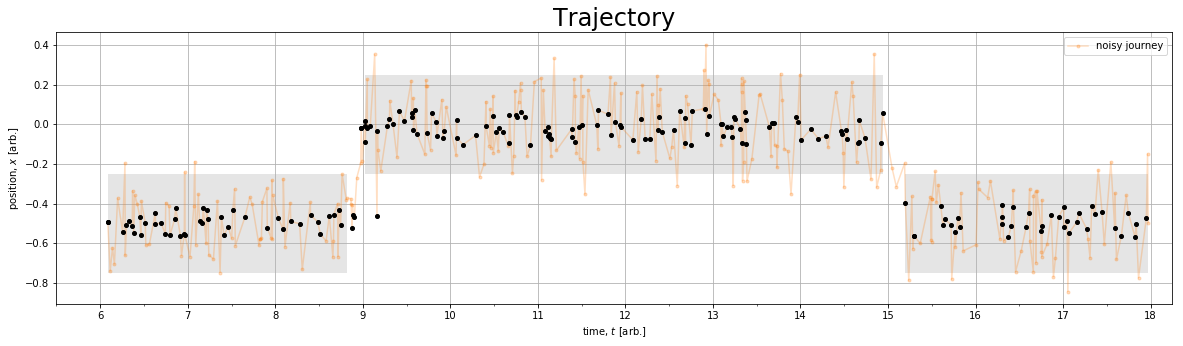

In [803]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

finals_index = 2

final_extended_clusters = []

for c in final_clusters:

    #ax.plot(time_arr[c], noise_arr[c], "co", markersize=14, markerfacecolor='None')
    
    # Get cluster
    #c = final_clusters[finals_index]

    print((noise_arr[c].min(), noise_arr[c].max()))

    # extend time forwards
    print("Backwards")

    new_end = get_time_ind(time_arr, time_arr[c[0]], 2*time_thresh, -1)
    print(c[0],c[-1],new_end)

    last_ind = c[0]
    keep_going = True
    while keep_going:

        cc = get_iqr_mask_x(noise_arr[new_end:c[1]], new_end, (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        print(cc[0], cc[-1], new_end, last_ind)

        extended_cluster_ = cc.copy()
        if cc[0] != last_ind:
            print("not = ", cc[0], cc[-1], new_end, last_ind)
            last_ind = cc[0]
        else:
            break

        new_end = get_time_ind(time_arr, time_arr[last_ind], 2*time_thresh, -1)

    print()

    print(extended_cluster_[0], extended_cluster_[-1], new_end)

    print()

    #noise_arr[c[0]:new_end]
    #ax.plot(time_arr[c[0]:new_end], noise_arr[c[0]:new_end], "mo", markersize=10, markerfacecolor='None')

    #ax.plot(time_arr[extended_cluster_], noise_arr[extended_cluster_], "k+", markersize=10, markerfacecolor='None')


    #ccc = get_bounded_events(noise_arr[c[0]:new_end], c, noise_arr[c].min(), noise_arr[c].max())

    #print("this",_get_iqr(noise_arr[c]))
    #print(ccc[0],ccc[-1])

    if cc[-1]!=last_ind:
        last_ind = cc[-1]

    new_end = get_time_ind(time_arr,time_arr[new_end], 2*time_thresh, 1)


    #ccc = get_bounded_events(noise_arr[cc], cc, noise_arr[cc].min(), noise_arr[cc].max())
        
    
    
    # extend time forwards
    print("Forwards")

    new_end = get_time_ind(time_arr,time_arr[c[-1]], 2*time_thresh, 1)
    print(c[0],c[-1],new_end)

    last_ind = c[-1]
    keep_going = True
    while keep_going:

        cc = get_iqr_mask_x(noise_arr[c[0]:new_end], c[0], (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        print(cc[0],cc[-1],new_end, last_ind)
        extended_cluster = cc.copy()
        if cc[-1] != last_ind:
            print("not =", cc[0],cc[-1],new_end, last_ind)
            last_ind = cc[-1]
        else:
            break

        new_end = get_time_ind(time_arr, time_arr[last_ind], 2*time_thresh, 1)

    print(extended_cluster[0],extended_cluster[-1],new_end)
    
    #final_extended_clusters = extended_cluster.copy()
    print()

    #noise_arr[c[0]:new_end]
    #ax.plot(time_arr[c[0]:new_end], noise_arr[c[0]:new_end], "mo", markersize=10, markerfacecolor='None')

    #ax.plot(time_arr[extended_cluster], noise_arr[extended_cluster], "kx", markersize=10, markerfacecolor='None')
    
    extended_cluster = np.concatenate([extended_cluster_, extended_cluster])
    
    final_extended_clusters.append(extended_cluster.tolist())
    
    ax.plot(time_arr[extended_cluster], noise_arr[extended_cluster], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [794]:
prec, rec, conmat = eval_synth_data(segments, time_arr, final_extended_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.975
 0.992
[[  2  10]
 [  3 394]]


In [708]:
int((len(segments)+1)/2)

3

In [ ]:
def eval_synth_data_clusters(segments, time_arr, clusters):

    """
    Evaluate based on individual clusters
    """
    
    expected_nr_of_stays = int((len(segments)+1)/2)
    predicted_nr_of_stays = len(clusters)
    
    if expected_nr_of_stays != predicted_nr_of_stays:
        return np.nan, np.nan, np.nan
    
    
    # Get the actual stay indices and create the labels for each event
    from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays
    
    true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
    true_labels = np.zeros(time_arr.shape)

    for pair in true_indices:
        true_labels[pair[0]:pair[1]+1] = 1

    # Get the predicted labels for each event
    final_pairs = []
    for clust in clusters:
        final_pairs.append([clust[0],clust[-1]])
    pred_labels = np.zeros(time_arr.shape)

    for pair in final_pairs:
        pred_labels[pair[0]:pair[1]+1] = 1

    # Evaluate using prec. and rec.
    from sklearn.metrics import precision_score, recall_score, confusion_matrix

    prec = precision_score(true_labels, pred_labels)
    rec  = recall_score(true_labels, pred_labels)

    # Eval. using confuse. matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)
    
    return prec, rec, conf_mat

In [795]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays
from sklearn.metrics import precision_score, recall_score, confusion_matrix
    
expected_nr_of_stays = int((len(segments)+1)/2)

for n in range(0,len(segments),2):
    
    true_indices = get_stay_indices(get_adjusted_stays(segments[n:n+1], time_arr), time_arr)[0]    
    print(n, true_indices[0], true_indices[-1])
    
    nn = int(n/2)
    clust = final_extended_clusters[nn]
    print(nn, clust[0], clust[-1])    
    
    pair = [min(true_indices[0],clust[0]), max(true_indices[-1],clust[-1])]
    print(pair)
    
    true_labels = np.zeros(time_arr.shape)
    true_labels[true_indices[0]:true_indices[1]+1] = 1
        
        
    pred_labels = np.zeros(time_arr.shape)
    pred_labels[clust[0]:clust[-1]+1] = 1      
    
 
    prec = precision_score(true_labels, pred_labels)
    rec  = recall_score(true_labels, pred_labels)        
    
    print(prec, rec)
    break

0 0 94
0 0 112
[0, 112]
0.8407079646017699 1.0


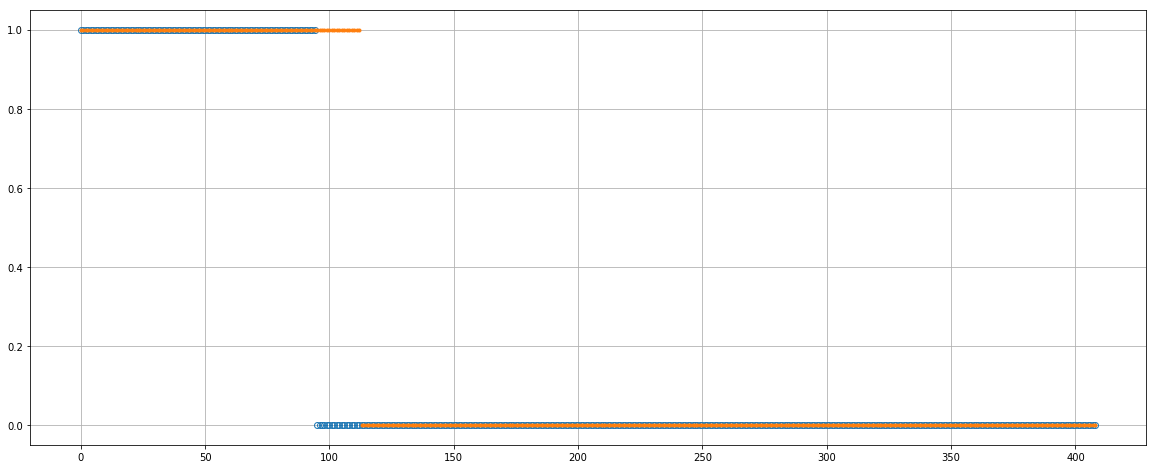

In [796]:
plt.figure(figsize=[20,8])
plt.plot(true_labels, 'o', markerfacecolor='None')
plt.plot(pred_labels, '.')
plt.grid()

In [788]:
def get_no_overlap(clusters):
    
    c1 = clusters[0]
    c2 = clusters[1]

    if c1[-1]>c2[0]:

        print(abs(time_arr[c1[-2]]-time_arr[c1[-1]]), abs(time_arr[c1[-1]]-time_arr[c2[0]]))
        if abs(time_arr[c1[-2]]-time_arr[c1[-1]]) < abs(time_arr[c1[-1]]-time_arr[c2[0]]):

            print("c2[0] is the outlier")
            pass
        else:
            print("c1[-1] is the outlier")   
            _ = c1.pop(-1)

            final_clusters.append(c1)
            
    for c1, c2 in zip(final_extended_clusters[1:-1],final_extended_clusters[2:]):

        print(c1[0],c1[-1], c2[0],c2[-1])
        if c1[-1]>c2[0]:

            print(abs(time_arr[c1[-2]]-time_arr[c1[-1]]), abs(time_arr[c1[-1]]-time_arr[c2[0]]))
            if abs(time_arr[c1[-2]]-time_arr[c1[-1]]) < abs(time_arr[c1[-1]]-time_arr[c2[0]]):
                pass
            else:
                print("c1[-1] is the outlier")   
                _ = c1.pop(-1)    
                final_clusters.append(c1)
                
    c1 = clusters[-2]
    c2 = clusters[-1]

    if c1[-1]>c2[0]:

        print(abs(time_arr[c1[-2]]-time_arr[c1[-1]]), abs(time_arr[c1[-1]]-time_arr[c2[0]]))
        if abs(time_arr[c1[-2]]-time_arr[c1[-1]]) < abs(time_arr[c1[-1]]-time_arr[c2[0]]):

            print("c2[0] is the outlier")
            pass
        else:
            print("c1[-1] is the outlier")   
            _ = c1.pop(-1)

            final_clusters.append(c1)    
            
    return final_clusters

In [806]:
ultimate_clusters = get_no_overlap(final_extended_clusters.copy())

0.2577777777777772 0.17999999999999972
c1[-1] is the outlier
103 317 321 406


In [809]:
for c in final_extended_clusters:
    print(c[0],c[-1])

0 100
103 317
321 406


In [807]:
for c in ultimate_clusters:
    print(c[0],c[-1])

0 90
103 300
325 403
0 100


(5.5, 18.25)

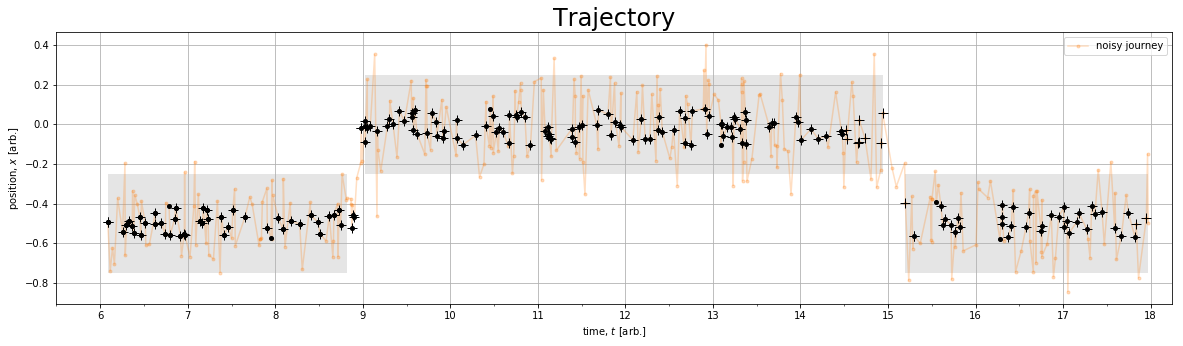

In [808]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')


for c in ultimate_clusters:

    ax.plot(time_arr[c], noise_arr[c], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [31]:
from helper__gaps import merge_cluster_pair, get_gap_dist

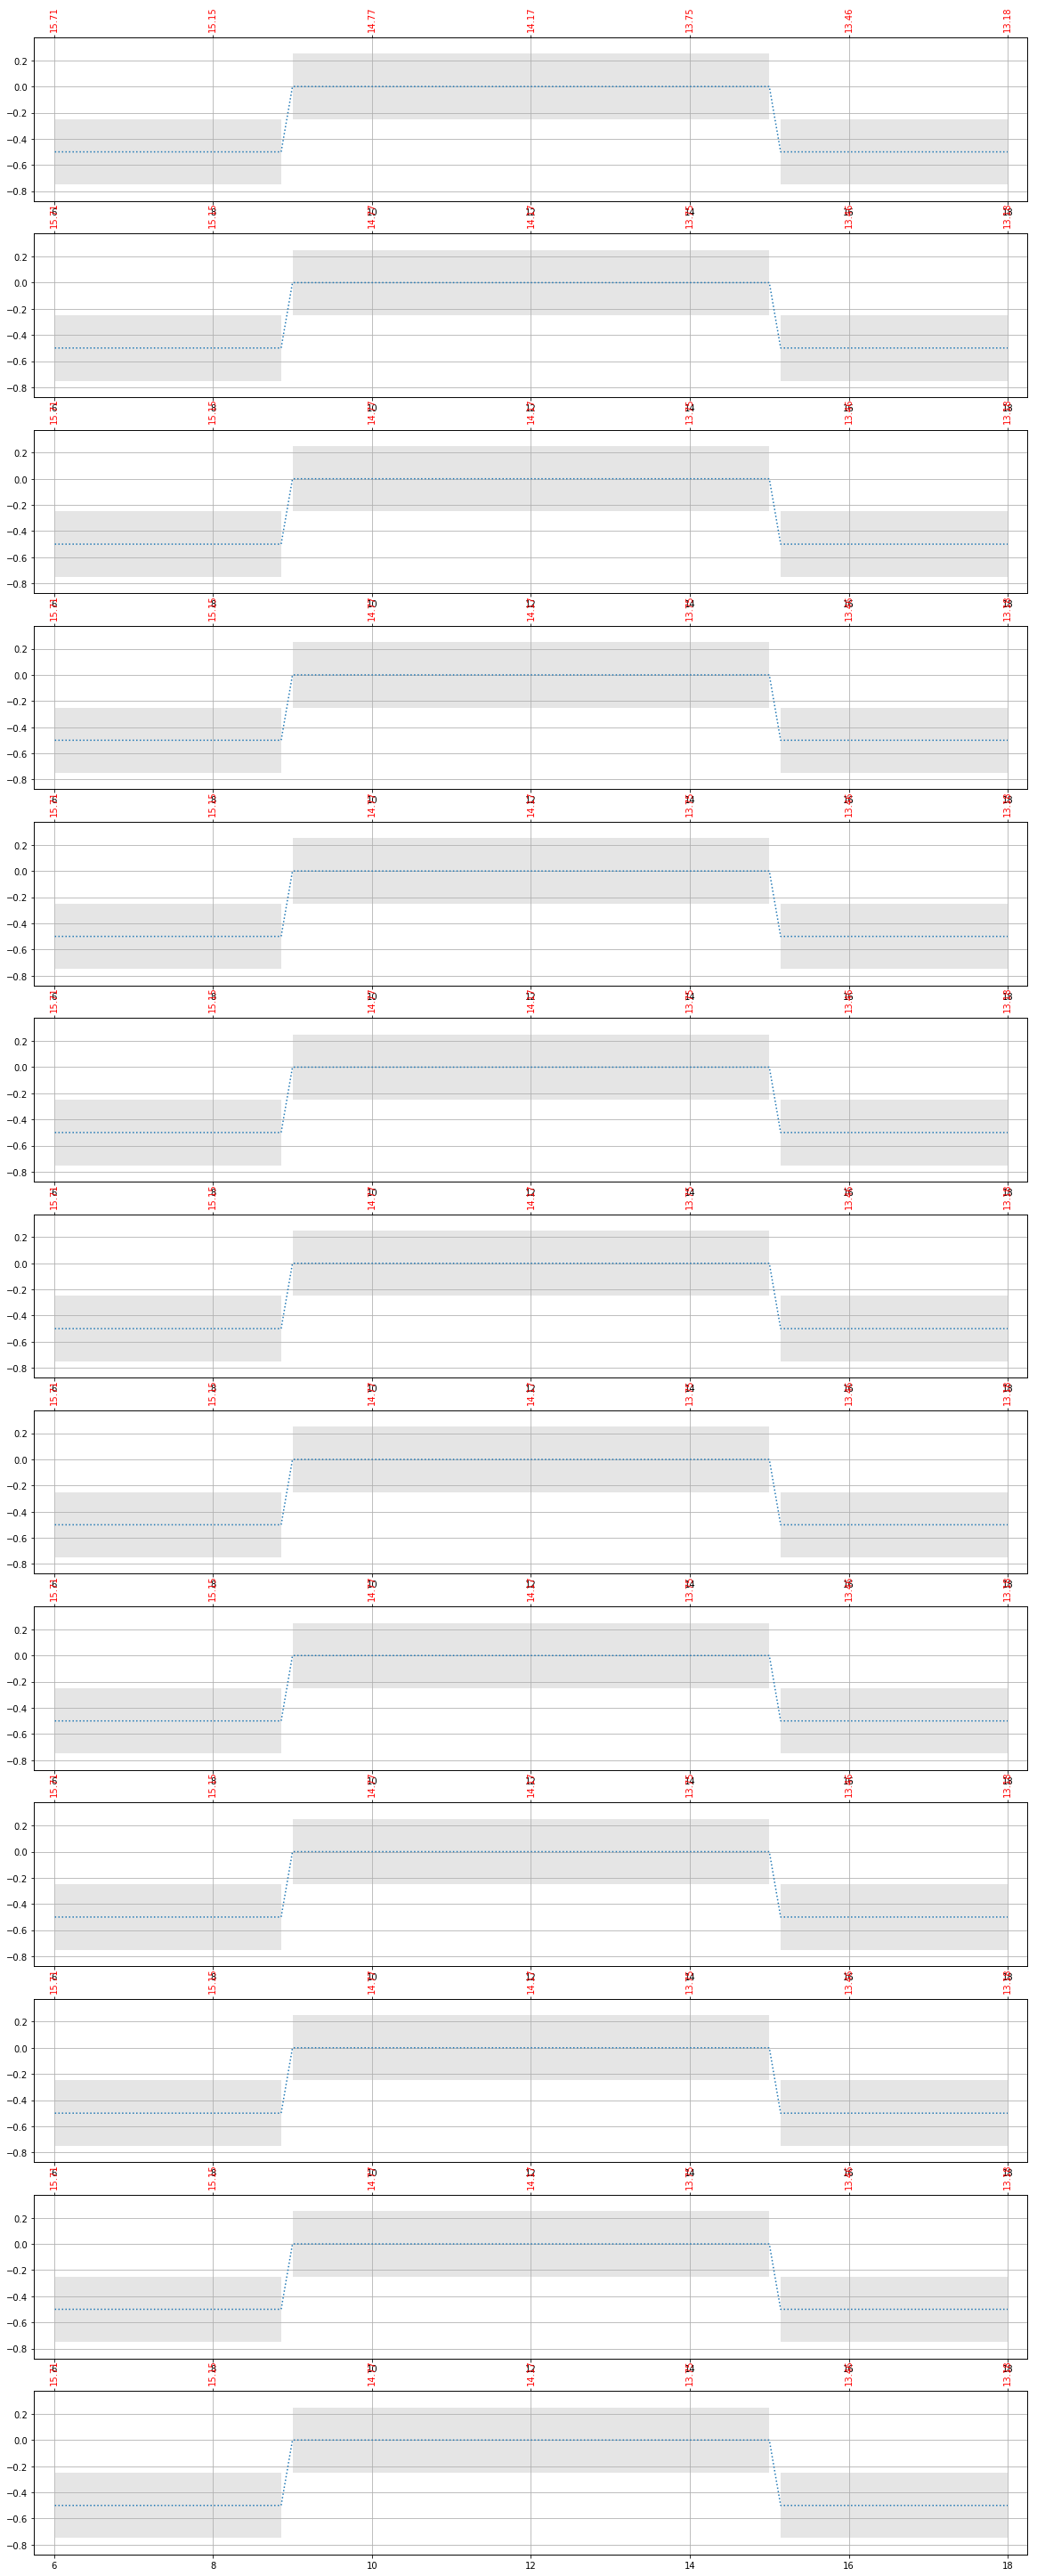

In [48]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters2 = clusters.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")    
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    ymin = raw_arr.min()-1.5*dist_thresh
    
    ax.set_ylim([ymin,ymax])
    
    try:
        axt = ax.twiny()

        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]     
        dists = [get_gap_dist(noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters2 = merge_cluster_pair(new_clusters2, min_index).copy()

        for c1,c2 in zip(new_clusters2[:-1],new_clusters2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[c1] - x_med)):7.3f} {abs(np.median(noise_arr[c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters2, time_arr, noise_arr, axt, **kwargs_unfilled)
    except: pass

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')
    axt.set_xlim(ax.get_xlim())

    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    


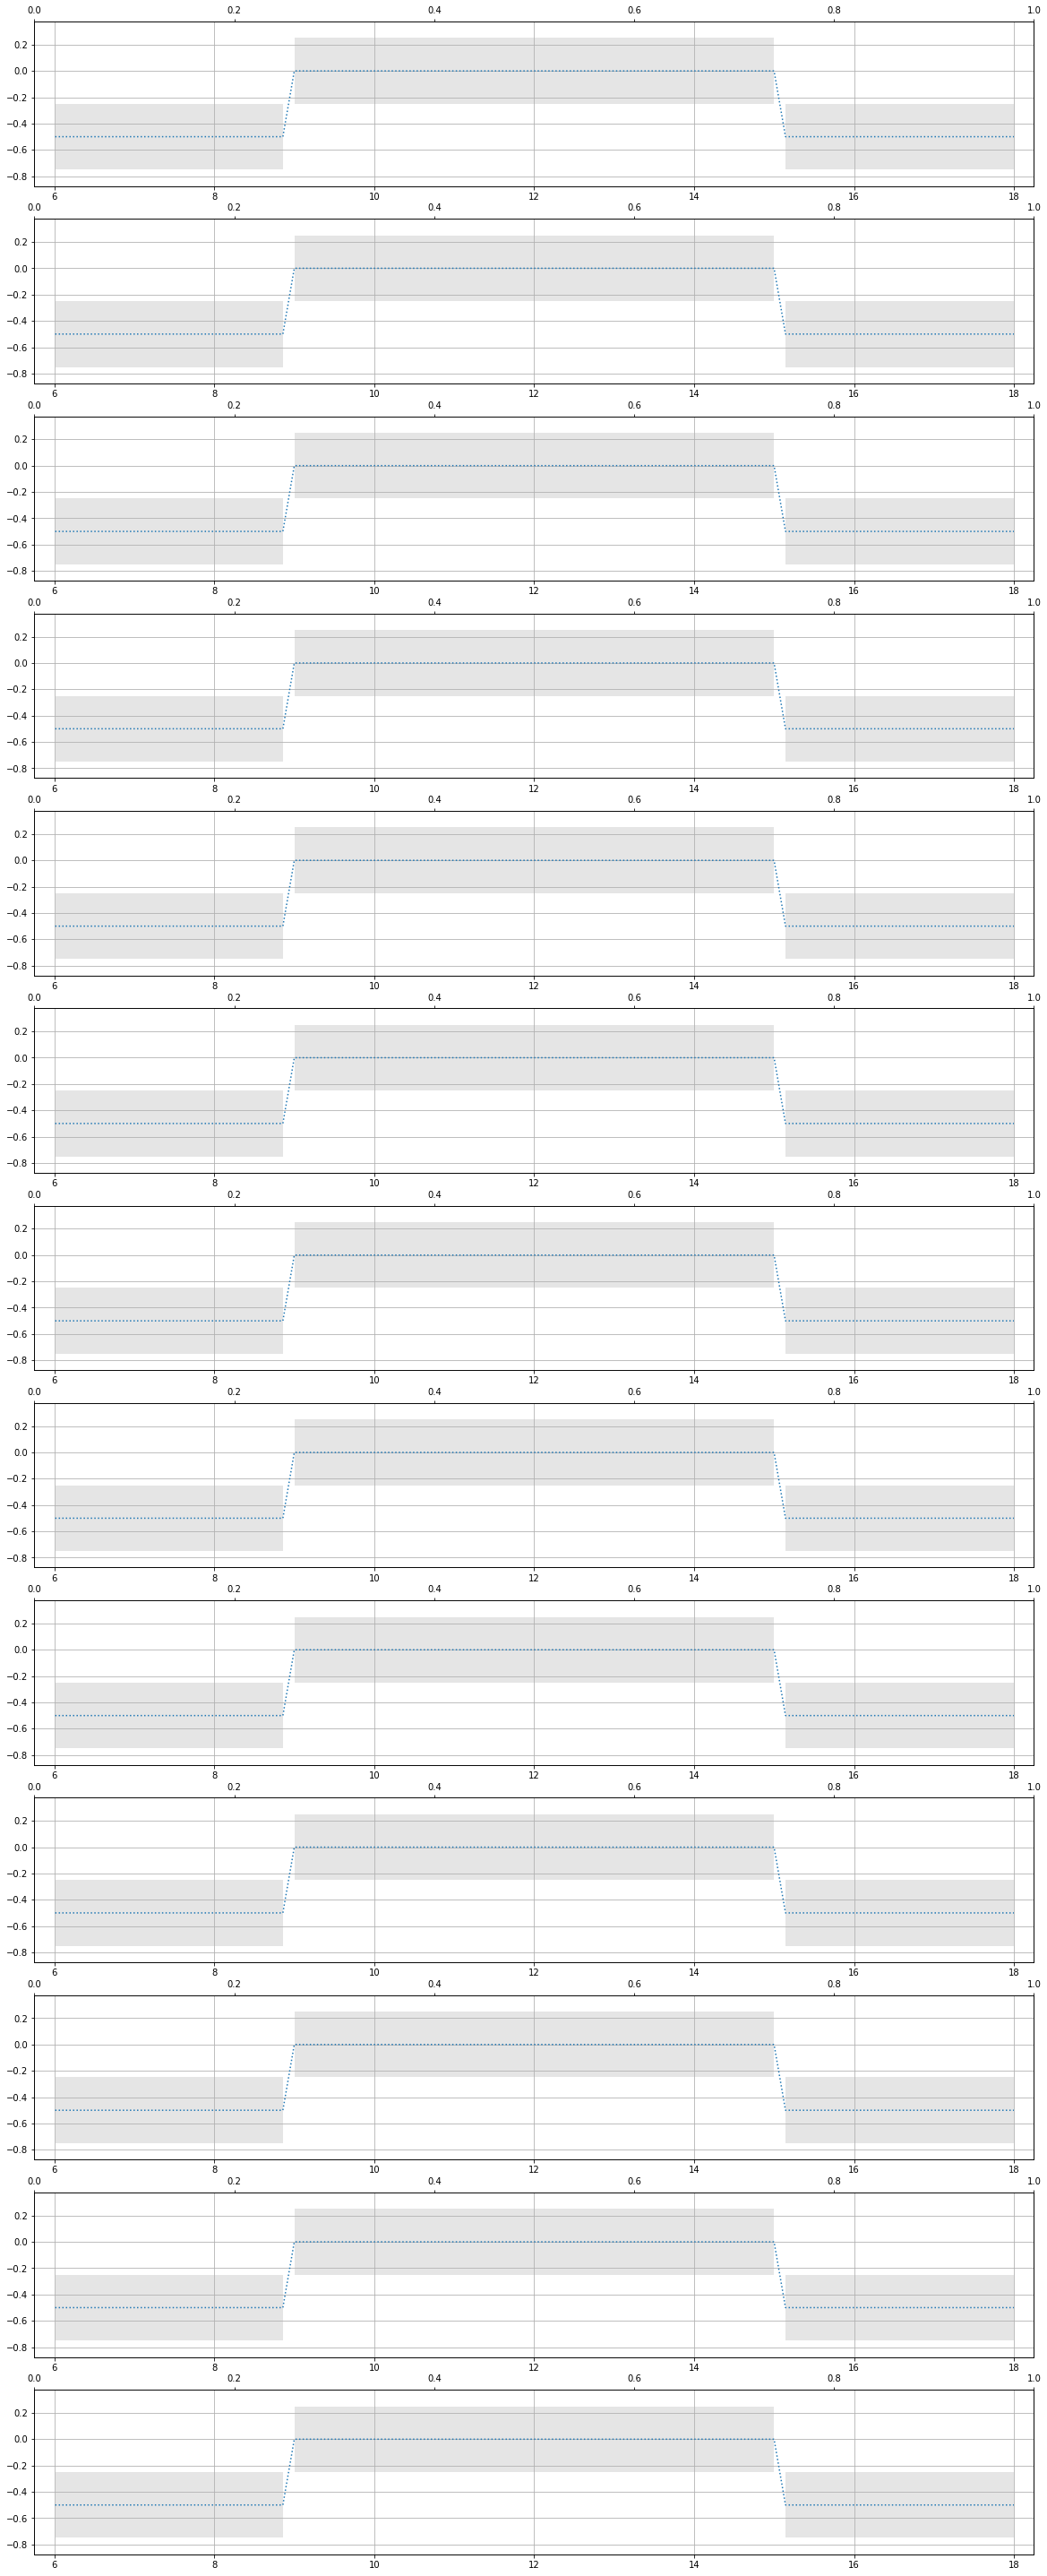

In [49]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters_rev2 = clusters_rev.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    ymin = raw_arr.min()-1.5*dist_thresh
    ax.set_ylim([ymin,ymax])
    
    try:
        axt = ax.twiny()


        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr[::-1],noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]     
        dists = [get_gap_dist(noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters_rev2 = merge_cluster_pair(new_clusters_rev2, min_index).copy()

        for c1,c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr[::-1], noise_arr[::-1], time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[::-1][c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[::-1][c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[::-1][c1] - x_med)):7.3f} {abs(np.median(noise_arr[::-1][c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters_rev2, time_arr, noise_arr, axt, **kwargs_unfilled)


        for label in axt.get_xticklabels():
            label.set_rotation(90)
        axt.set_xticklabels(labels, visible=True, color='red')
        axt.set_xlim(ax.get_xlim())

    except: pass
    
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    
